### Data Storage in big data and distributed systems

Efficient storage can dramatically improve performance, particularly when operating repeatedly from disk.

Decompressing text and parsing CSV files is expensive. One of the most effective strategies with medium data is to use a binary storage format like HDF5 or Parquet. Often the performance gains from doing this is sufficient so that you can switch back to using Pandas again instead of using dask.dataframe.

In this section we'll learn how to efficiently arrange and store your datasets in on-disk binary formats. We'll use the following:

Main Take-aways

+ Storage formats affect performance by an order of magnitude
+ Text data will keep even a fast format like HDF5 slow
+ A combination of binary formats, column storage, and partitioned data turns one second wait times into 80ms wait times.

In [1]:
import os
filename = os.path.join('data', 'accounts.*.csv')
filename

'data/accounts.*.csv'

In [2]:
import dask.dataframe as dd
df_csv = dd.read_csv(filename)
df_csv.head()

,id,names,amount
0,9,Wendy,15
1,15,Victor,77
2,381,Bob,3064
3,358,Ingrid,2041
4,299,Kevin,204


In [3]:
target = os.path.join('data', 'accounts.h5')
target



'data/accounts.h5'

In [4]:
%time df_csv.to_hdf(target, '/data')

CPU times: user 2.47 s, sys: 352 ms, total: 2.82 s
Wall time: 4.85 s


['data/accounts.h5', 'data/accounts.h5', 'data/accounts.h5']

In [4]:

# same data as before
df_hdf = dd.read_hdf(target, '/data')
df_hdf.head()

,id,names,amount
0,9,Wendy,15
1,15,Victor,77
2,381,Bob,3064
3,358,Ingrid,2041
4,299,Kevin,204


In [6]:
%time df_csv.amount.sum().compute()

CPU times: user 906 ms, sys: 279 ms, total: 1.19 s
Wall time: 558 ms


4186059719

In [5]:
%time df_hdf.amount.sum().compute()

CPU times: user 377 ms, sys: 194 ms, total: 571 ms
Wall time: 1.56 s


4186059719

Sadly they are about the same, or perhaps even slower.

The culprit here is names column, which is of object dtype and thus hard to store efficiently. There are two problems here:

How do we store text data like names efficiently on disk?
Why did we have to read the names column when all we wanted was amount


In [6]:
target = os.path.join('data', 'accounts_optimized.h5')
%time df_hdf.categorize(columns=['names']).to_hdf(target, '/data')

CPU times: user 2.12 s, sys: 360 ms, total: 2.48 s
Wall time: 3.49 s


['data/accounts_optimized.h5',
 'data/accounts_optimized.h5',
 'data/accounts_optimized.h5']

In [7]:
df_hdf = dd.read_hdf(target, '/data')
df_hdf.head()

,id,names,amount
0,9,Wendy,15
1,15,Victor,77
2,381,Bob,3064
3,358,Ingrid,2041
4,299,Kevin,204


In [8]:

# But loads more quickly
%time df_hdf.amount.sum().compute()

CPU times: user 154 ms, sys: 38.2 ms, total: 192 ms
Wall time: 197 ms


4186059719

Using the appropiate file extension and compression it's ncessary when you have Big data problems. 
Even though using HDF5/Parquet can use more space than a CSV when you store it on disk, when you have to do complex computation it improves the perfomances. 
This is due to the nauture of the file encoding, in other words, it depends on how the data are stored inside the file. While CSV is a text file, HDF5 files are ```binary files``` and this improve the general perfomances during the elaborations.

Furthermore, HDF5 is a standard that allows to store file into "distributed filesystem".
Distributed filesystems are a type of filesystems that works over LAN/WAN or internet networks.
When you have a cluster with thousands of workers, you can create a distributed filesystem that is shared between each node. In other words, each worker node may access to the same resources.

This is usefull specially when you have to store some partial computed data that should be used by different workers. In this case, in fact, a worker node X can acess to the resources generated by a worker node Y whit a reduced overhead and without store the data enterily in RAM.

Even though HDF5 and Parquet are ones of the best standards for distributed file systems nowadays it's possible to store any type of file. Anyway HDF5 and Parquet formats still remain the best ones for Big data approaches

### Remote files
When you have to work with big data and clusters, you should be involved in remote resources management and loading.
Dask can access various cloud- and cluster-oriented data storage services such as Amazon S3/HDFS/Google Cloud and Dropbox.

This approach it is really usefull specially when you have to distribute the data over sperated workers that don't have a disrtibuted file system.

Advantages:

+ scalable, 
+ secure storage

Disadvantages:
+ network speed becomes bottleneck

The way to set up dataframes (and other collections) remains very similar to before. Note that the data here is available anonymously, but in general an extra parameter storage_options= can be passed with further details about how to interact with the remote storage.

Let's try to download and analyze a remote file:

In [30]:
# this file allows to load data from a Amazon S3 Cloud storage, 
# unfortunately the file is larger then 2GB on our machines dont' allows to you to download it!
# Feel free to try it on you own machine at home!
# taxi = dd.read_csv('s3://nyc-tlc/trip data/yellow_tripdata_2015-*.csv')

taxi = dd.read_csv('https://www.dropbox.com/s/17ui51hwpoqeb4p/fhv_tripdata_2015-01.csv?dl=1')
taxi

,Dispatching_base_num,Pickup_date,locationID
npartitions=2,,,
,object,object,float64
,...,...,...
,...,...,...


In [10]:
taxi.head()

,Dispatching_base_num,Pickup_date,locationID
0,B00013,2015-01-01 00:30:00,NaN
1,B00013,2015-01-01 01:22:00,NaN
2,B00013,2015-01-01 01:23:00,NaN
3,B00013,2015-01-01 01:44:00,NaN
4,B00013,2015-01-01 02:00:00,NaN


In [11]:
taxi.tail()

,Dispatching_base_num,Pickup_date,locationID
684980,B02765,2015-01-31 23:59:02,169.0
684981,B02765,2015-01-31 23:59:07,80.0
684982,B02765,2015-01-31 23:59:34,186.0
684983,B02765,2015-01-31 23:59:40,181.0
684984,B02765,2015-01-31 23:59:48,79.0


How you can see from ```taxi.head()```, some data are disturbed. In this case there are some rows without a value for column ```locationID```. 
Let's remove those data and try to make a simple exercise!

In [33]:
taxi = taxi.dropna()
taxi.head()
taxi = taxi.repartition(npartitions=12)

### Exercise 1

Calculate the max number of taxi ride per location (column ```locationID```) and see the computation graph.

Max number of ride: 85742


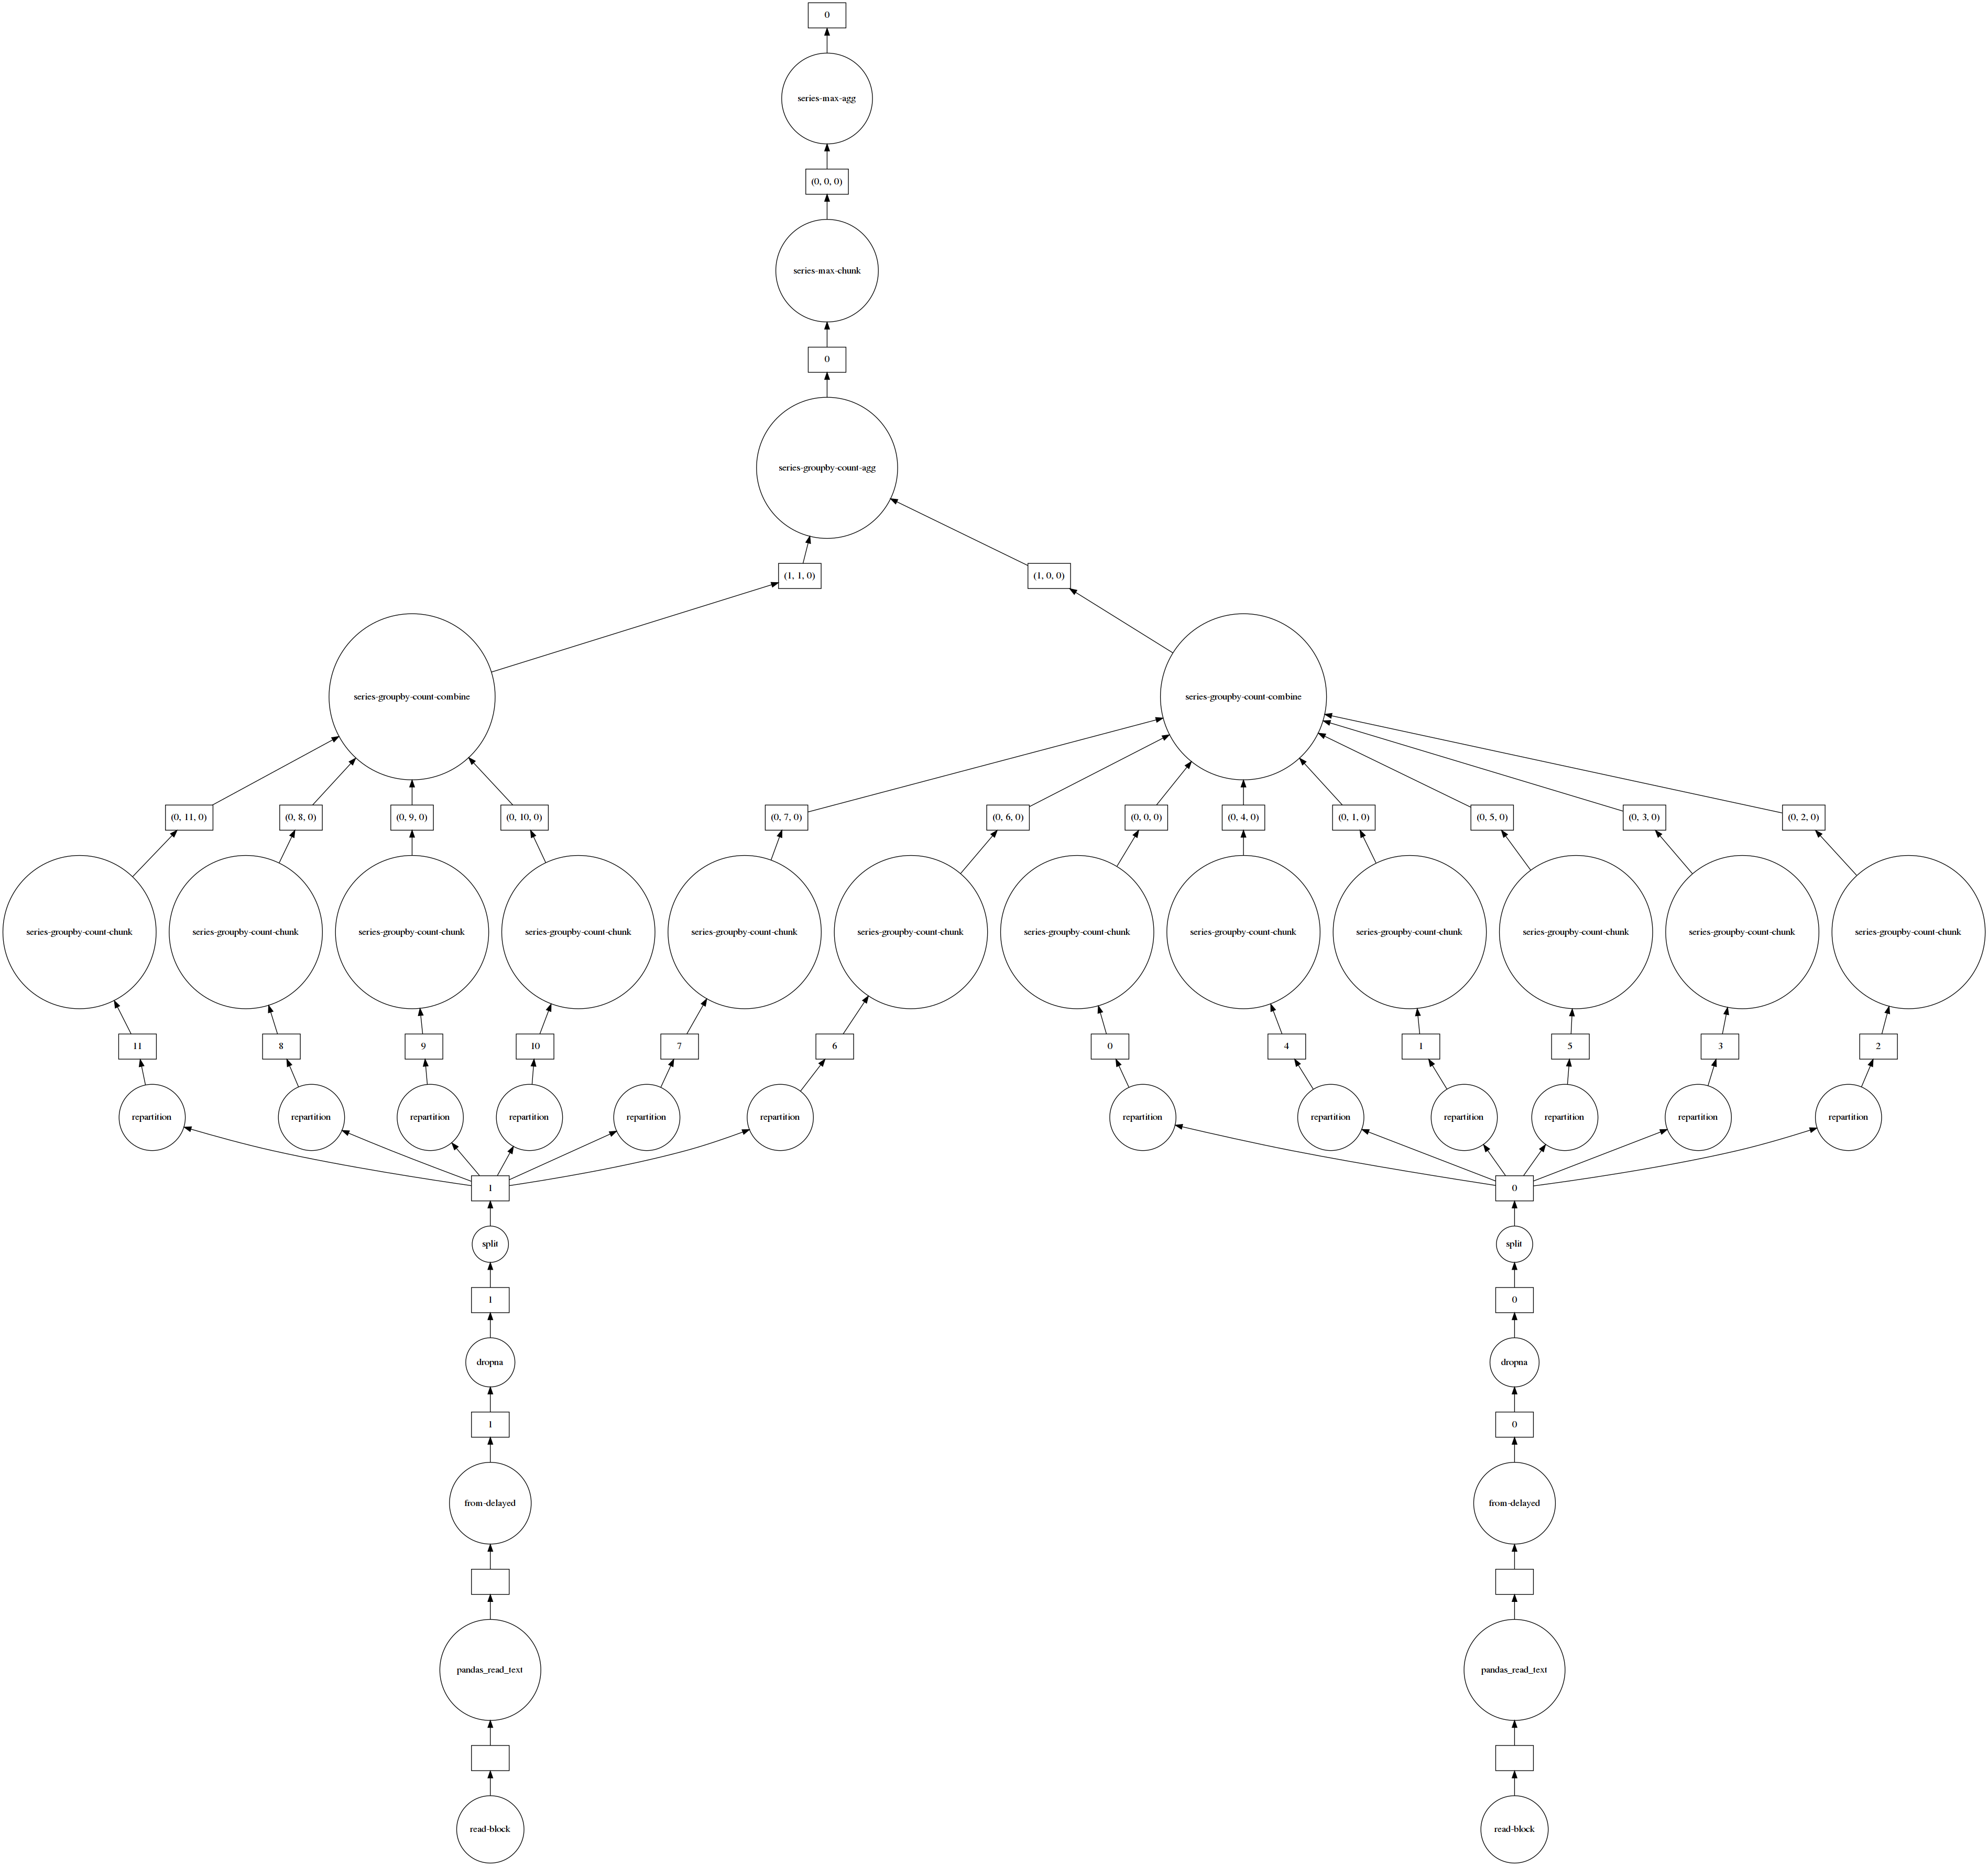

In [40]:
print("Max number of ride fo a location: "+str(taxi.groupby('locationID').locationID.count().max().compute()))
taxi.groupby('locationID').locationID.count().max().visualize()

### Exercise 2

Calculate the mean and the std number of taxi ride per location (column ```locationID```) without repeating the same operations. Then See the computation graph.

In [ ]:
mean = taxi.groupby('locationID').locationID.count().mean()
std = taxi.groupby('locationID').locationID.count().std()